# Creating a regression model Felling/Prices 

In [22]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
import scipy.stats as sp
import statsmodels.stats.diagnostic as ssd

In [23]:
df1=pd.DataFrame(pd.read_csv ('C:/Users/borsh/OneDrive/Рабочий стол/BI/projects/ForestlyActivitiesProject/project data/data-1760379126636.csv'))
df2=pd.DataFrame(pd.read_csv ('C:/Users/borsh/OneDrive/Рабочий стол/BI/projects/ForestlyActivitiesProject/scripts/data-1759582857171.csv'))
df2
df2_=df2.drop([0,1,2])
df2_
df = df1.merge(df2_, on='year', how='outer')
df = df.sort_values('year')
df_=df.drop(0)# 2018 has extremely low value, that get a bad correlation
df_

,wood_fuel_cost,year,industrial_rw_cost,sum
1,488.376000,2019,1404.528000,17886600.0
2,450.210271,2020,1316.084700,16773000.0
3,568.388960,2021,2290.164254,16666900.0
4,814.320000,2022,2823.324000,15085100.0
5,911.826630,2023,2649.323396,15252100.0
6,906.448000,2024,2887.800112,14885800.0


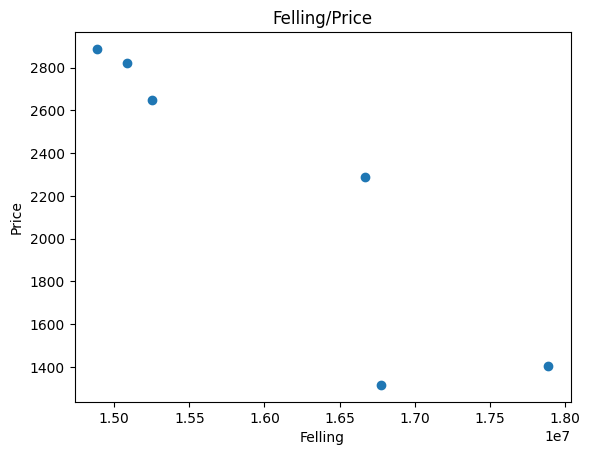

In [24]:
plt.scatter(x=df_['sum'], y=df_['industrial_rw_cost'])
plt.title('Felling/Price')
plt.xlabel('Felling')
plt.ylabel('Price')
plt.show()

## Biuld the OLS 

In [25]:
x = sm.add_constant(df_['sum'])
y = df_['industrial_rw_cost']
OLS_basic = sm.OLS(y,x).fit()
print(OLS_basic.summary())

                            OLS Regression Results                            
Dep. Variable:     industrial_rw_cost   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     17.61
Date:                Thu, 30 Oct 2025   Prob (F-statistic):             0.0137
Time:                        17:35:40   Log-Likelihood:                -42.250
No. Observations:                   6   AIC:                             88.50
Df Residuals:                       4   BIC:                             88.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.076e+04   2038.285      5.280      0.0

C:\Users\borsh\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


p-value < 0.05 that means that dependence is linear

## Build regresstion with lags

In [26]:
df_['sum_l']=df_['sum'].shift(1)
df_lag=df_.dropna()

x_lag = sm.add_constant(df_lag['sum_l'])
y_lag= df_lag['industrial_rw_cost']

OLS_lag= sm.OLS(y_lag,x_lag).fit()
print(OLS_lag.summary())

                            OLS Regression Results                            
Dep. Variable:     industrial_rw_cost   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     5.588
Date:                Thu, 30 Oct 2025   Prob (F-statistic):             0.0991
Time:                        17:35:42   Log-Likelihood:                -36.257
No. Observations:                   5   AIC:                             76.51
Df Residuals:                       3   BIC:                             75.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9681.2455   3089.420      3.134      0.0

C:\Users\borsh\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


That means that price less depence by past values of felling, but correlation still strong, r=0.8, but p-value> 0.05 that means that log-relation not detected   

## Checking the lags

In [27]:
res=OLS_lag.resid
stat,p=sp.shapiro(res)
print('Shapiro p-value: ', p)

Shapiro p-value:  0.5865020576026468


p>0.05 that means than we have normal residuals 

## Confidence interval (basic model)

In [28]:
pred = OLS_basic.get_prediction(x)
pred_summary = pred.summary_frame(alpha = 0.5)
print(pred_summary[['mean','mean_ci_lower','mean_ci_upper']])

          mean  mean_ci_lower  mean_ci_upper
1  1276.671852    1079.870428    1473.473275
2  1867.194216    1746.500199    1987.888232
3  1923.457168    1807.704364    2039.209971
4  2762.257703    2623.064891    2901.450514
5  2673.700559    2544.574700    2802.826419
6  2867.942964    2715.503162    3020.382766


## Prediction interval(basic model)

In [29]:
pred = OLS_basic.get_prediction(x)
pred_summary = pred.summary_frame(alpha = 0.5)
print(pred_summary[['mean','obs_ci_lower','obs_ci_upper']])

          mean  obs_ci_lower  obs_ci_upper
1  1276.671852    957.732847   1595.610856
2  1867.194216   1588.701246   2145.687185
3  1923.457168   1647.069758   2199.844577
4  2762.257703   2475.263056   3049.252349
5  2673.700559   2391.451067   2955.950052
6  2867.942964   2574.294907   3161.591022


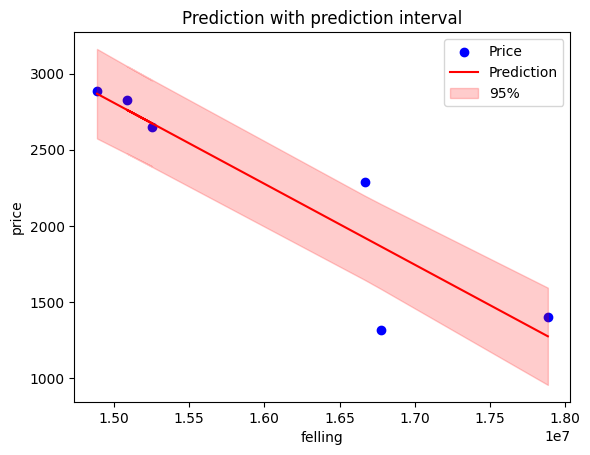

In [30]:
plt.scatter(df_['sum'],df_['industrial_rw_cost'],color ='blue',label = 'Price')
plt.plot(df_['sum'],pred_summary['mean'],color ='red', label = 'Prediction')
plt.fill_between(df_['sum'], pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'],color = 'red', alpha =0.2, label = '95%')
plt.xlabel('felling')
plt.ylabel('price')
plt.title('Prediction with prediction interval')
plt.legend()
plt.show()

## Get forecast for the next 3 years

In [36]:
X=sm.add_constant(pd.Series(pd.concat([df_['sum'],pd.Series([1.409218e+07,1.359063e+07, 1.308907e+07])]), name='felling value'))
prediction= OLS_basic.get_prediction(X)
forecast=prediction.summary_frame(alpha=0.05)
forecast.index = X['felling value']
print(forecast[['mean','mean_ci_lower','mean_ci_upper','obs_ci_lower','obs_ci_upper']])


                      mean  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
felling value                                                            
17886600.0     1276.671852     538.977104    2014.366599     81.153930   
16773000.0     1867.194216    1414.782132    2319.606300    823.285095   
16666900.0     1923.457168    1489.566835    2357.347500    887.440575   
15085100.0     2762.257703    2240.504333    3284.011073   1686.480710   
15252100.0     2673.700559    2189.682371    3157.718748   1615.710405   
14885800.0     2867.942964    2296.534285    3439.351644   1767.226180   
14092180.0     3288.785600    2488.990897    4088.580302   2053.981516   
13590630.0     3554.748685    2596.856444    4512.640926   2212.129191   
13089070.0     3820.717073    2699.383100    4942.051047   2357.002811   

               obs_ci_upper  
felling value                
17886600.0      2472.189773  
16773000.0      2911.103337  
16666900.0      2959.473760  
15085100.0      3838.034696  
15252